In [1]:
# iEEG imports
from ieeg.auth import Session

# Scientific computing imports
import numpy as np
import scipy as sc
import pandas as pd
import json
from scipy.linalg import hankel
from tqdm import tqdm
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import cohen_kappa_score

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Imports for analysis
from seizure_detection_pipeline import prepare_segment, TRAIN_WIN, PRED_WIN

# OS imports
import os
from os.path import join as ospj
from os.path import exists as ospe
from utils import *
import sys
sys.path.append('/users/wojemann/iEEG_processing')
plt.rcParams['image.cmap'] = 'magma'

## Config

In [2]:
usr,passpath,datapath,prodatapath,figpath,patient_table,rid_hup,pt_list = load_config(ospj('/mnt/leif/littlab/users/wojemann/stim-seizures/code','config.json'))

In [3]:
patient_table

,ptID,ieeg_ids,lf_stim,hf_stim,interictal_training
14,HUP224,"[HUP224_phaseII, HUP224_CCEP]",1,0,"[HUP224_phaseII, 5915]"
15,HUP225,"[HUP225_phaseII, HUP225_CCEP]",1,0,"[HUP225_phaseII, 71207]"
16,HUP229,"[HUP229_phaseII, HUP229_CCEP]",1,0,"[HUP229_phaseII, 149146]"
17,HUP230,"[HUP230_phaseII, HUP230_CCEP]",1,0,"[HUP230_phaseII, 25350]"
18,HUP235,"[HUP235_phaseII, HUP235_CCEP]",1,1,"[HUP235_phaseII, 307651]"
19,HUP238,"[HUP238_phaseII, HUP238_CCEP]",1,0,"[HUP238_phaseII, 100011]"
20,HUP246,"[HUP246_phaseII, HUP246_CCEP]",1,0,"[HUP246_phaseII, 100000]"
21,HUP247,"[HUP247_phaseII, HUP247_CCEP]",1,0,"[HUP247_phaseII, 17590]"
22,HUP249,"[HUP249_phaseII, HUP249_CCEP]",1,0,"[HUP249_phaseII, 24112]"
23,HUP250,"[HUP250_phaseII, HUP250_CCEP]",1,0,"[HUP250_phaseII, 24841]"


## Formatting Model Predictions

### Channel agreement functions

In [4]:
def wideform_preds(element,all_labels):
    return [label in element for label in all_labels]

def shortform_preds(element,all_labels):
    a = np.array(all_labels)[element]
    return a
def apply_dice_score(row):
    all_chs = row.all_chs
    for col in ['ueo_consensus','ueo_any','sec_consensus','sec_any']:
        row[col+'_chs'] = shortform_preds(row[col],all_chs)
        for pred in ['strict','loose']:
            ch_preds = row[f'{col[:3]}_chs_{pred}']
            if (len(ch_preds) + len(row[col+'_chs'])) == 0:
                row[f'{col}_{pred}_dice'] = 0
            else:
                row[f'{col}_{pred}_dice'] = dice_score(row[col+'_chs'],ch_preds)
    return row

def apply_kappa_score(row):
    all_chs = row.all_chs
    for col in ['ueo_chs_strict','ueo_chs_loose','sec_chs_strict','sec_chs_loose']:
        # need to turn model predictions into the wideform
        row[col+'_bool'] = wideform_preds(row[col],all_chs)
        for annot in ['consensus','any']:
            ch_preds = row[f'{col[:3]}_{annot}']
            # if (sum(ch_preds) + sum(row[col+'_bool'])) == 0:
            #     row[f'{col}_{annot}_kappa'] = 0
            # else:
            row[f'{col}_{annot}_kappa'] = cohen_kappa_score(row[col+'_bool'],ch_preds)
    return row

### Channel level

In [5]:
# Loading in human annotations with consensus annotation already created
annotations_df = pd.read_pickle(ospj(prodatapath,"stim_seizure_information_consensus.pkl"))
annotations_df.columns = ['Patient' if c == 'patient' else c for c in annotations_df.columns]
# Loading in predicted channels for all models from generate_model_annotations.py
predicted_channels = pd.read_pickle(ospj(prodatapath,"predicted_channels.pkl"))
predicted_channels = predicted_channels[predicted_channels.to_annotate == 1]
# Sorting
predicted_channels.sort_values('approximate_onset',inplace=True)
annotations_df.sort_values('approximate_onset',inplace=True)
# Creating a merged table with human and machine annotations based on approximate seizure onset time
pred_channels_wannots = pd.merge_asof(predicted_channels,
                                    annotations_df[['approximate_onset','Patient','all_chs','ueo_consensus','ueo_any','sec_consensus','sec_any']],
                                    on='approximate_onset',by='Patient',
                                    tolerance = 240,
                                    direction='nearest')
pred_channels_wannots.dropna(axis=0,subset='ueo_consensus',inplace=True)
pred_channels_wannots.sort_values(['Patient','iEEG_ID','approximate_onset'],inplace=True)
pred_channels_wdice = pred_channels_wannots.apply(apply_dice_score,axis=1)
pred_channels_wkappa = pred_channels_wannots.apply(apply_kappa_score,axis=1)



In [12]:
pred_channels_wdice.to_pickle(ospj(prodatapath,f"predicted_channels_wdice.pkl"))
pred_channels_wkappa.to_pickle(ospj(prodatapath,f"predicted_channels_wkappa.pkl"))

### Region level

In [13]:
# Tranforming human annotations to regions
pt_groups = annotations_df.groupby('Patient')
for pt,group in pt_groups:
    region_path = ospj(prodatapath,pt,'electrode_localizations_dkt.pkl')
    if not ospe(region_path):
        continue
    electrode_regions = pd.read_pickle(region_path)
    for idx,row in group.iterrows():
        for col in ['ueo_consensus','ueo_any','sec_consensus','sec_any']:
            chs = np.array(row.all_chs)[row[col]]
            electrode_locals = np.array([l for l in electrode_regions[electrode_regions.name.isin(chs)]['label'].unique() if l != 'EmptyLabel'])
            annotations_df.at[idx,col+'_rs'] = electrode_locals
        annotations_df.at[idx,'all_rs'] = electrode_regions[electrode_regions.name.isin(row['all_chs'])]['label'].unique()

In [14]:
# Transforming model predictions to regions
pt_groups = predicted_channels.groupby('Patient')
for pt,group in pt_groups:
    region_path = ospj(prodatapath,pt,'electrode_localizations_dkt.pkl')
    if not ospe(region_path):
        continue
    electrode_regions = pd.read_pickle(region_path)
    for idx,row in group.iterrows():
        for col in ['ueo_chs_strict','ueo_chs_loose','sec_chs_strict','sec_chs_loose']:
            electrode_locals = np.array([l for l in electrode_regions[electrode_regions.name.isin(row[col])]['label'].unique() if l != 'EmptyLabel'])
            predicted_channels.at[idx,col.split('_')[0]+'_rs_'+col.split('_')[2]] = electrode_locals

In [15]:
predicted_channels[['Patient','iEEG_ID','model','threshold','ueo_rs_strict']].head(12)

,Patient,iEEG_ID,model,threshold,ueo_rs_strict
1086,HUP229,HUP229_phaseII,LSTM,0.75,"[ left amygdala , left hippocampus , left in..."
1104,HUP229,HUP229_phaseII,AbsSlp,0.60,"[ left amygdala , left superior temporal , l..."
1103,HUP229,HUP229_phaseII,AbsSlp,0.55,"[ left amygdala , left superior temporal , l..."
1102,HUP229,HUP229_phaseII,AbsSlp,0.50,"[ left amygdala , left superior temporal , l..."
1101,HUP229,HUP229_phaseII,AbsSlp,0.45,"[ left amygdala , left superior temporal , l..."
1100,HUP229,HUP229_phaseII,AbsSlp,0.40,"[ left amygdala , left superior temporal , l..."
1099,HUP229,HUP229_phaseII,AbsSlp,0.35,"[ left amygdala , left superior temporal , l..."
1098,HUP229,HUP229_phaseII,AbsSlp,0.30,"[ left amygdala , left superior temporal , l..."
1097,HUP229,HUP229_phaseII,AbsSlp,0.25,"[ left amygdala , left superior temporal , l..."
1096,HUP229,HUP229_phaseII,AbsSlp,0.20,"[ left amygdala , left superior temporal , l..."


In [16]:
pred_regions_wannots = pd.merge_asof(predicted_channels,
                                        annotations_df[['approximate_onset','Patient','all_rs','ueo_consensus_rs','ueo_any_rs','sec_consensus_rs','sec_any_rs']],
                                        on='approximate_onset',by='Patient',
                                        tolerance = 240,
                                        direction='nearest')
pred_regions_wannots.dropna(axis=0,subset='stim',inplace=True)
pred_regions_wannots.sort_values(['Patient','iEEG_ID','approximate_onset','threshold','model'],inplace=True)

In [17]:
pred_regions_wannots

,Patient,iEEG_ID,model,stim,approximate_onset,ueo_time_consensus,threshold,ueo_chs_strict,ueo_chs_loose,sec_chs_strict,...,to_annotate,ueo_rs_strict,ueo_rs_loose,sec_rs_strict,sec_rs_loose,all_rs,ueo_consensus_rs,ueo_any_rs,sec_consensus_rs,sec_any_rs
995,HUP224,HUP224_phaseII,AbsSlp,1.0,71156.5900,71156.5900,0.00,"[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",...,1.0,"[ left amygdala , left middle temporal , lef...","[ left amygdala , left middle temporal , lef...","[ left amygdala , left middle temporal , lef...","[ left amygdala , left middle temporal , lef...","[EmptyLabel, left amygdala , left middle tem...","[ left amygdala , left hippocampus ]","[ left amygdala , left hippocampus ]",left hippocampus,"[ left amygdala , left hippocampus ]"
945,HUP224,HUP224_phaseII,LSTM,1.0,71156.5900,71156.5900,0.00,"[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",...,1.0,"[ left amygdala , left middle temporal , lef...","[ left amygdala , left middle temporal , lef...","[ left amygdala , left middle temporal , lef...","[ left amygdala , left middle temporal , lef...","[EmptyLabel, left amygdala , left middle tem...","[ left amygdala , left hippocampus ]","[ left amygdala , left hippocampus ]",left hippocampus,"[ left amygdala , left hippocampus ]"
954,HUP224,HUP224_phaseII,LSTMX,1.0,71156.5900,71156.5900,0.00,"[LA01, LA02, LA03, LA04, LA05, LB01, LB02, LB0...","[LA01, LA02, LA03, LA04, LA05, LA06, LB01, LB0...","[LA01, LA02, LA03, LA04, LA05, LB01, LB02, LB0...",...,1.0,"[ left amygdala , left hippocampus , right h...","[ left amygdala , left hippocampus , left fu...","[ left amygdala , left hippocampus ]","[ left amygdala , left hippocampus , left fu...","[EmptyLabel, left amygdala , left middle tem...","[ left amygdala , left hippocampus ]","[ left amygdala , left hippocampus ]",left hippocampus,"[ left amygdala , left hippocampus ]"
996,HUP224,HUP224_phaseII,AbsSlp,1.0,71156.5900,71156.5900,0.05,"[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",...,1.0,"[ left amygdala , left middle temporal , lef...","[ left amygdala , left middle temporal , lef...","[ left amygdala , left middle temporal , lef...","[ left amygdala , left middle temporal , lef...","[EmptyLabel, left amygdala , left middle tem...","[ left amygdala , left hippocampus ]","[ left amygdala , left hippocampus ]",left hippocampus,"[ left amygdala , left hippocampus ]"
1007,HUP224,HUP224_phaseII,LSTM,1.0,71156.5900,71156.5900,0.05,"[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",...,1.0,"[ left amygdala , left middle temporal , lef...","[ left amygdala , left middle temporal , lef...","[ left amygdala , left middle temporal , lef...","[ left amygdala , left middle temporal , lef...","[EmptyLabel, left amygdala , left middle tem...","[ left amygdala , left hippocampus ]","[ left amygdala , left hippocampus ]",left hippocampus,"[ left amygdala , left hippocampus ]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2631,HUP266,HUP266_phaseII,LSTM,0.0,418859.4191,418859.4191,0.95,"[R01, R01, R01, R01, R01, R01, R01, R01, R01, ...","[R01, R02, RB04, RB05]","[R01, R01, R01, R01, R01, R01, R01, R01, R01, ...",...,1.0,"[ right posterior cingulate , right lateral v...","[ right posterior cingulate , right lateral v...","[ right posterior cingulate , right lateral v...","[ right posterior cingulate , right lateral v...","[ right posterior cingulate , EmptyLabel, rig...","[ right cerebellum exterior , right fusiform ]","[ right posterior cingulate , right lateral v...","[ right posterior cingulate , right lateral v...","[ righ

In [18]:
def apply_region_kappa(row):
    all_rs = row.all_rs
    for col in ['ueo_rs_strict','ueo_rs_loose','sec_rs_strict','sec_rs_loose']:
        bool_col = wideform_preds(row[col],all_rs)
        for annot in ['consensus','any']:
            r_annots = wideform_preds(row[f'{col[:3]}_{annot}_rs'],all_rs)
            row[f'{col}_{annot}_kappa'] = cohen_kappa_score(bool_col,r_annots)
    return row
pred_regions_wkappa = pred_regions_wannots.apply(apply_region_kappa,axis=1)

In [19]:
pred_regions_wkappa

,Patient,iEEG_ID,model,stim,approximate_onset,ueo_time_consensus,threshold,ueo_chs_strict,ueo_chs_loose,sec_chs_strict,...,sec_consensus_rs,sec_any_rs,ueo_rs_strict_consensus_kappa,ueo_rs_strict_any_kappa,ueo_rs_loose_consensus_kappa,ueo_rs_loose_any_kappa,sec_rs_strict_consensus_kappa,sec_rs_strict_any_kappa,sec_rs_loose_consensus_kappa,sec_rs_loose_any_kappa
995,HUP224,HUP224_phaseII,AbsSlp,1.0,71156.5900,71156.5900,0.00,"[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",...,left hippocampus,"[ left amygdala , left hippocampus ]",0.005277,0.005277,0.005277,0.005277,0.002548,0.005277,0.002548,0.005277
945,HUP224,HUP224_phaseII,LSTM,1.0,71156.5900,71156.5900,0.00,"[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",...,left hippocampus,"[ left amygdala , left hippocampus ]",0.442308,0.442308,0.377682,0.377682,0.292683,0.524590,0.240838,0.442308
954,HUP224,HUP224_phaseII,LSTMX,1.0,71156.5900,71156.5900,0.00,"[LA01, LA02, LA03, LA04, LA05, LB01, LB02, LB0...","[LA01, LA02, LA03, LA04, LA05, LA06, LB01, LB0...","[LA01, LA02, LA03, LA04, LA05, LB01, LB02, LB0...",...,left hippocampus,"[ left amygdala , left hippocampus ]",0.781955,0.781955,0.632911,0.632911,0.650602,1.000000,0.472727,0.781955
996,HUP224,HUP224_phaseII,AbsSlp,1.0,71156.5900,71156.5900,0.05,"[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",...,left hippocampus,"[ left amygdala , left hippocampus ]",0.005277,0.005277,0.005277,0.005277,0.002548,0.005277,0.002548,0.005277
1007,HUP224,HUP224_phaseII,LSTM,1.0,71156.5900,71156.5900,0.05,"[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",...,left hippocampus,"[ left amygdala , left hippocampus ]",0.524590,0.524590,0.524590,0.524590,0.292683,0.524590,0.292683,0.524590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2631,HUP266,HUP266_phaseII,LSTM,0.0,418859.4191,418859.4191,0.95,"[R01, R01, R01, R01, R01, R01, R01, R01, R01, ...","[R01, R02, RB04, RB05]","[R01, R01, R01, R01, R01, R01, R01, R01, R01, ...",...,"[ right posterior cingulate , right lateral v...","[ right posterior cingulate , right lateral v...",-0.190476,0.545455,-0.235294,0.285714,0.705882,0.705882,0.444444,0.444444
2645,HUP266,HUP266_phaseII,LSTMX,0.0,418859.4191,418859.4191,0.95,"[R01, R01, R01, R01, R01, R01, R01, R01, R01, ...","[R01, R02, RA02, RA03, RA06, RA07, RA08, RA09,...","[R01, R01, R01, R01, R01, R01, R01, R01, R01, ...",...,"[ right posterior cingulate , right lateral v...","[ right posterior cingulate , right lateral v...",-0.092715,0.146341,-0.127168,-0.046512,0.146341,0.146341,0.047619,0.047619
2587,HUP266,HUP266_phaseII,AbsSlp,0.0,418859.4191,418859.4191,1.00,[],[],[],...,"[ right posterior cingulate , right lateral v...","[ right posterior cingulate , right lateral v...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2632,HUP266,HUP266_phaseII,LSTM,0.0,418859.4191,418859.4191,1.00,[],[],[],...,"[ right posterior cingulate , right lateral v...","[ right posterior cingulate , right lateral v...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [20]:
pred_regions_wkappa.to_pickle(ospj(prodatapath,'predicted_regions_wkappa.pkl'))

## Channel Agreement Optimization

### DICE

In [21]:
anntype='consensus'
mdl_anntype = 'strict'
montage = 'bipolar'
mdl_preds = pd.read_pickle(ospj(prodatapath,f"predicted_channels_wdice.pkl"))

mdl_preds_sorted = mdl_preds.sort_values(['Patient','approximate_onset','threshold','model'])
mdl_preds_sorted.head()
mdl_preds_sorted.columns

Index(['Patient', 'iEEG_ID', 'model', 'stim', 'approximate_onset',
       'ueo_time_consensus', 'threshold', 'ueo_chs_strict', 'ueo_chs_loose',
       'sec_chs_strict', 'sec_chs_loose', 'to_annotate', 'all_chs',
       'ueo_consensus', 'ueo_any', 'sec_consensus', 'sec_any',
       'ueo_consensus_chs', 'ueo_consensus_strict_dice',
       'ueo_consensus_loose_dice', 'ueo_any_chs', 'ueo_any_strict_dice',
       'ueo_any_loose_dice', 'sec_consensus_chs', 'sec_consensus_strict_dice',
       'sec_consensus_loose_dice', 'sec_any_chs', 'sec_any_strict_dice',
       'sec_any_loose_dice'],
      dtype='object')

In [22]:
melt_cols = [f'ueo_{anntype}_{mdl_anntype}_dice',f'sec_{anntype}_{mdl_anntype}_dice']
keep_cols = [c for c in mdl_preds_sorted.columns if c not in melt_cols]
mdl_preds_long = mdl_preds_sorted.melt(id_vars=keep_cols,var_name='annot',value_name='dice')
mdl_preds_long.head()

,Patient,iEEG_ID,model,stim,approximate_onset,ueo_time_consensus,threshold,ueo_chs_strict,ueo_chs_loose,sec_chs_strict,...,ueo_any_chs,ueo_any_strict_dice,ueo_any_loose_dice,sec_consensus_chs,sec_consensus_loose_dice,sec_any_chs,sec_any_strict_dice,sec_any_loose_dice,annot,dice
0,HUP224,HUP224_phaseII,AbsSlp,1.0,71156.59,71156.59,0.00,"[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",...,"[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LB0...",0.142012,0.126984,"[LB01, LB02, LB03, LC01, LC02]",0.054945,"[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LB0...",0.130952,0.117021,ueo_consensus_strict_dice,0.130952
1,HUP224,HUP224_phaseII,LSTM,1.0,71156.59,71156.59,0.00,"[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",...,"[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LB0...",0.666667,0.545455,"[LB01, LB02, LB03, LC01, LC02]",0.285714,"[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LB0...",0.647059,0.536585,ueo_consensus_strict_dice,0.628571
2,HUP224,HUP224_phaseII,LSTMX,1.0,71156.59,71156.59,0.00,"[LA01, LA02, LA03, LA04, LA05, LB01, LB02, LB0...","[LA01, LA02, LA03, LA04, LA05, LA06, LB01, LB0...","[LA01, LA02, LA03, LA04, LA05, LB01, LB02, LB0...",...,"[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LB0...",0.857143,0.727273,"[LB01, LB02, LB03, LC01, LC02]",0.454545,"[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LB0...",0.880000,0.785714,ueo_consensus_strict_dice,0.814815
3,HUP224,HUP224_phaseII,AbsSlp,1.0,71156.59,71156.59,0.05,"[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",...,"[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LB0...",0.142012,0.126984,"[LB01, LB02, LB03, LC01, LC02]",0.054945,"[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LB0...",0.130952,0.117021,ueo_consensus_strict_dice,0.130952
4,HUP224,HUP224_phaseII,LSTM,1.0,71156.59,71156.59,0.05,"[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",...,"[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LB0...",0.727273,0.600000,"[LB01, LB02, LB03, LC01, LC02]",0.303030,"[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LB0...",0.687500,0.564103,ueo_consensus_strict_dice,0.687500


Text(0.5, 0.98, 'Model Annotator Agreement - consensus')

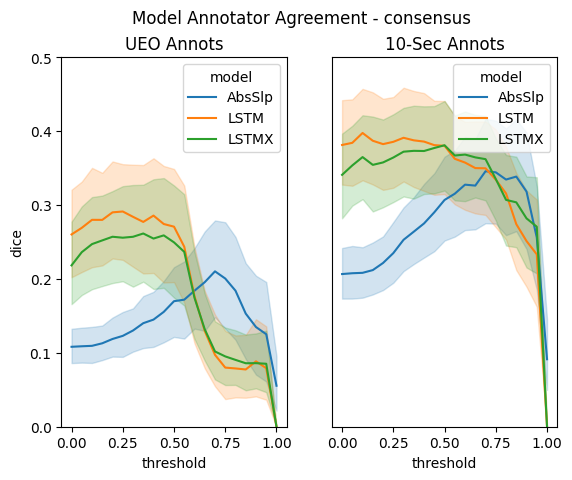

In [23]:
fig,axs = plt.subplots(1,2)
sns.lineplot(data=mdl_preds_long[mdl_preds_long.annot == f'ueo_{anntype}_{mdl_anntype}_dice'],x='threshold',y='dice',hue='model',ax=axs[0])
axs[0].set_ylim((0,.5))
axs[0].set_title('UEO Annots')
sns.lineplot(data=mdl_preds_long[mdl_preds_long.annot == f'sec_{anntype}_{mdl_anntype}_dice'],x='threshold',y='dice',hue='model',ax=axs[1])
axs[1].set_ylim((0,.5))
axs[1].set_yticks([])
axs[1].set_ylabel('')
axs[1].set_title('10-Sec Annots')
fig.suptitle(f'Model Annotator Agreement - {anntype}')

### Kappa

In [24]:
anntype='consensus'
mdl_anntype = 'strict'
montage = 'bipolar'
mdl_preds = pd.read_pickle(ospj(prodatapath,f"predicted_channels_wkappa.pkl"))
# mdl_preds = mdl_preds[mdl_preds.stim == 0]
mdl_preds_sorted = mdl_preds.sort_values(['Patient','approximate_onset','threshold','model'])
# mdl_preds_sorted.head()

In [25]:
melt_cols = [f'ueo_chs_{mdl_anntype}_{anntype}_kappa',f'sec_chs_{mdl_anntype}_{anntype}_kappa']
keep_cols = [c for c in mdl_preds_sorted.columns if c not in melt_cols]
mdl_preds_long = mdl_preds_sorted.melt(id_vars=keep_cols,var_name='annot',value_name='kappa')
print(np.sort(mdl_preds.columns))
mdl_preds_long.head()

['Patient' 'all_chs' 'approximate_onset' 'iEEG_ID' 'model' 'sec_any'
 'sec_chs_loose' 'sec_chs_loose_any_kappa' 'sec_chs_loose_bool'
 'sec_chs_loose_consensus_kappa' 'sec_chs_strict'
 'sec_chs_strict_any_kappa' 'sec_chs_strict_bool'
 'sec_chs_strict_consensus_kappa' 'sec_consensus' 'stim' 'threshold'
 'to_annotate' 'ueo_any' 'ueo_chs_loose' 'ueo_chs_loose_any_kappa'
 'ueo_chs_loose_bool' 'ueo_chs_loose_consensus_kappa' 'ueo_chs_strict'
 'ueo_chs_strict_any_kappa' 'ueo_chs_strict_bool'
 'ueo_chs_strict_consensus_kappa' 'ueo_consensus' 'ueo_time_consensus']


,Patient,iEEG_ID,model,stim,approximate_onset,ueo_time_consensus,threshold,ueo_chs_strict,ueo_chs_loose,sec_chs_strict,...,ueo_chs_loose_bool,ueo_chs_loose_consensus_kappa,ueo_chs_loose_any_kappa,sec_chs_strict_bool,sec_chs_strict_any_kappa,sec_chs_loose_bool,sec_chs_loose_consensus_kappa,sec_chs_loose_any_kappa,annot,kappa
0,HUP224,HUP224_phaseII,AbsSlp,1.0,71156.59,71156.59,0.00,"[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",...,"[True, True, True, True, True, True, True, Tru...",0.029635,0.032431,"[True, True, True, True, True, True, True, Tru...",0.045643,"[True, True, True, True, True, True, True, Tru...",0.013220,0.029635,ueo_chs_strict_consensus_kappa,0.045643
1,HUP224,HUP224_phaseII,LSTM,1.0,71156.59,71156.59,0.00,"[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",...,"[True, True, True, True, True, True, True, Tru...",0.474200,0.508127,"[True, True, True, True, True, True, True, Fal...",0.622642,"[True, True, True, True, True, True, True, Tru...",0.258065,0.501710,ueo_chs_strict_consensus_kappa,0.602499
2,HUP224,HUP224_phaseII,LSTMX,1.0,71156.59,71156.59,0.00,"[LA01, LA02, LA03, LA04, LA05, LB01, LB02, LB0...","[LA01, LA02, LA03, LA04, LA05, LA06, LB01, LB0...","[LA01, LA02, LA03, LA04, LA05, LB01, LB02, LB0...",...,"[True, True, True, True, True, True, False, Fa...",0.666570,0.707875,"[True, True, True, True, True, False, False, F...",0.873208,"[True, True, True, True, True, True, False, Fa...",0.435583,0.772502,ueo_chs_strict_consensus_kappa,0.803687
3,HUP224,HUP224_phaseII,AbsSlp,1.0,71156.59,71156.59,0.05,"[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",...,"[True, True, True, True, True, True, True, Tru...",0.029635,0.032431,"[True, True, True, True, True, True, True, Tru...",0.045643,"[True, True, True, True, True, True, True, Tru...",0.013220,0.029635,ueo_chs_strict_consensus_kappa,0.045643
4,HUP224,HUP224_phaseII,LSTM,1.0,71156.59,71156.59,0.05,"[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",...,"[True, True, True, True, True, True, True, Tru...",0.531961,0.568480,"[True, True, True, True, True, True, True, Fal...",0.666570,"[True, True, True, True, True, True, True, Tru...",0.276334,0.531961,ueo_chs_strict_consensus_kappa,0.666570


Text(0.5, 0.98, 'Model Annotator Agreement - consensus')

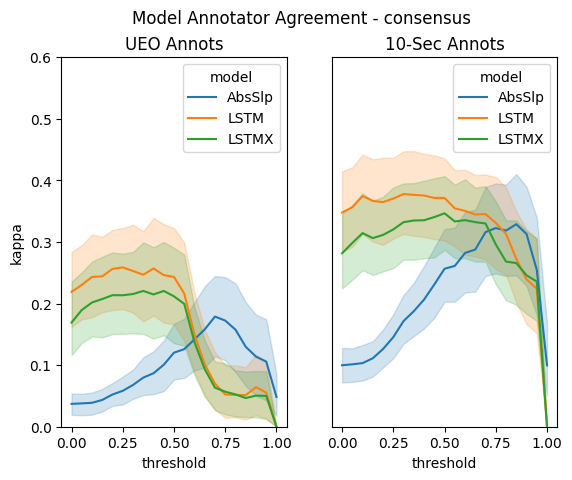

In [26]:
fig,axs = plt.subplots(1,2)
sns.lineplot(data=mdl_preds_long[mdl_preds_long.annot == f'ueo_chs_{mdl_anntype}_{anntype}_kappa'],x='threshold',y='kappa',hue='model',ax=axs[0])
axs[0].set_ylim((0,.6))
axs[0].set_title('UEO Annots')
sns.lineplot(data=mdl_preds_long[mdl_preds_long.annot == f'sec_chs_{mdl_anntype}_{anntype}_kappa'],x='threshold',y='kappa',hue='model',ax=axs[1])
axs[1].set_ylim((0,.6))
axs[1].set_yticks([])
axs[1].set_ylabel('')
axs[1].set_title('10-Sec Annots')
fig.suptitle(f'Model Annotator Agreement - {anntype}')

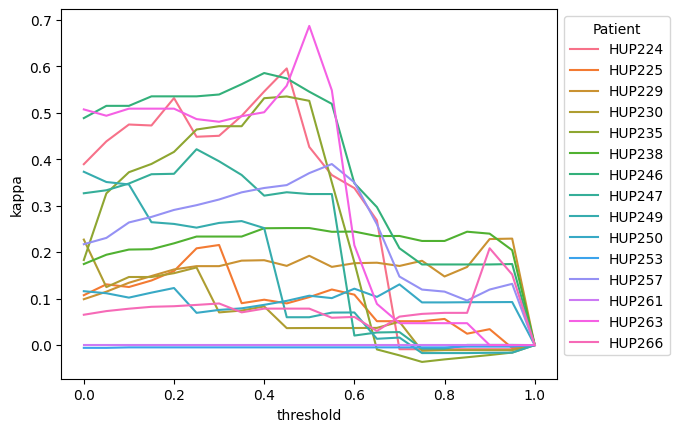

In [27]:
ax = sns.lineplot(data=mdl_preds_long[(mdl_preds_long.annot == f'ueo_chs_{mdl_anntype}_{anntype}_kappa') & (mdl_preds_long.model == 'LSTM')],x='threshold',y='kappa',hue='Patient',errorbar=None,)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

### Getting optimal threshold

In [28]:
mask = mdl_preds_sorted.model == 'LSTM'
ueo_df = mdl_preds_sorted[mask].groupby('threshold')[f'ueo_chs_{mdl_anntype}_{anntype}_kappa'].mean()
sec_df = mdl_preds_sorted[mask].groupby('threshold')[f'sec_chs_{mdl_anntype}_{anntype}_kappa'].mean()

In [29]:
print(ueo_df.index[ueo_df.iloc[:].argmax()])
print(sec_df.index[sec_df.iloc[:].argmax()])

0.25
0.30000000000000004


## Region Agreement Optimization

### Kappa

In [30]:
anntype='any'
mdl_anntype = 'loose'
montage = 'bipolar'
mdl_preds = pd.read_pickle(ospj(prodatapath,f"predicted_regions_wkappa.pkl"))
mdl_preds_sorted = mdl_preds.sort_values(['Patient','approximate_onset','threshold','model'])

In [31]:
mdl_preds_sorted[[col for col in mdl_preds_sorted.columns if 'kappa' in col]].fillna(0,inplace=True)
melt_cols = [f'ueo_rs_{mdl_anntype}_{anntype}_kappa',f'sec_rs_{mdl_anntype}_{anntype}_kappa']
keep_cols = [c for c in mdl_preds_sorted.columns if c not in melt_cols]
mdl_preds_long = mdl_preds_sorted.melt(id_vars=keep_cols,var_name='annot',value_name='kappa')
mdl_preds_long.head()

,Patient,iEEG_ID,model,stim,approximate_onset,ueo_time_consensus,threshold,ueo_chs_strict,ueo_chs_loose,sec_chs_strict,...,sec_consensus_rs,sec_any_rs,ueo_rs_strict_consensus_kappa,ueo_rs_strict_any_kappa,ueo_rs_loose_consensus_kappa,sec_rs_strict_consensus_kappa,sec_rs_strict_any_kappa,sec_rs_loose_consensus_kappa,annot,kappa
0,HUP224,HUP224_phaseII,AbsSlp,1.0,71156.59,71156.59,0.00,"[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",...,left hippocampus,"[ left amygdala , left hippocampus ]",0.005277,0.005277,0.005277,0.002548,0.005277,0.002548,ueo_rs_loose_any_kappa,0.005277
1,HUP224,HUP224_phaseII,LSTM,1.0,71156.59,71156.59,0.00,"[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",...,left hippocampus,"[ left amygdala , left hippocampus ]",0.442308,0.442308,0.377682,0.292683,0.524590,0.240838,ueo_rs_loose_any_kappa,0.377682
2,HUP224,HUP224_phaseII,LSTMX,1.0,71156.59,71156.59,0.00,"[LA01, LA02, LA03, LA04, LA05, LB01, LB02, LB0...","[LA01, LA02, LA03, LA04, LA05, LA06, LB01, LB0...","[LA01, LA02, LA03, LA04, LA05, LB01, LB02, LB0...",...,left hippocampus,"[ left amygdala , left hippocampus ]",0.781955,0.781955,0.632911,0.650602,1.000000,0.472727,ueo_rs_loose_any_kappa,0.632911
3,HUP224,HUP224_phaseII,AbsSlp,1.0,71156.59,71156.59,0.05,"[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",...,left hippocampus,"[ left amygdala , left hippocampus ]",0.005277,0.005277,0.005277,0.002548,0.005277,0.002548,ueo_rs_loose_any_kappa,0.005277
4,HUP224,HUP224_phaseII,LSTM,1.0,71156.59,71156.59,0.05,"[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",...,left hippocampus,"[ left amygdala , left hippocampus ]",0.524590,0.524590,0.524590,0.292683,0.524590,0.292683,ueo_rs_loose_any_kappa,0.524590


In [32]:
mdl_preds_sorted.columns

Index(['Patient', 'iEEG_ID', 'model', 'stim', 'approximate_onset',
       'ueo_time_consensus', 'threshold', 'ueo_chs_strict', 'ueo_chs_loose',
       'sec_chs_strict', 'sec_chs_loose', 'to_annotate', 'ueo_rs_strict',
       'ueo_rs_loose', 'sec_rs_strict', 'sec_rs_loose', 'all_rs',
       'ueo_consensus_rs', 'ueo_any_rs', 'sec_consensus_rs', 'sec_any_rs',
       'ueo_rs_strict_consensus_kappa', 'ueo_rs_strict_any_kappa',
       'ueo_rs_loose_consensus_kappa', 'ueo_rs_loose_any_kappa',
       'sec_rs_strict_consensus_kappa', 'sec_rs_strict_any_kappa',
       'sec_rs_loose_consensus_kappa', 'sec_rs_loose_any_kappa'],
      dtype='object')

Text(0.5, 0.98, 'Model Annotator Agreement - loose - any')

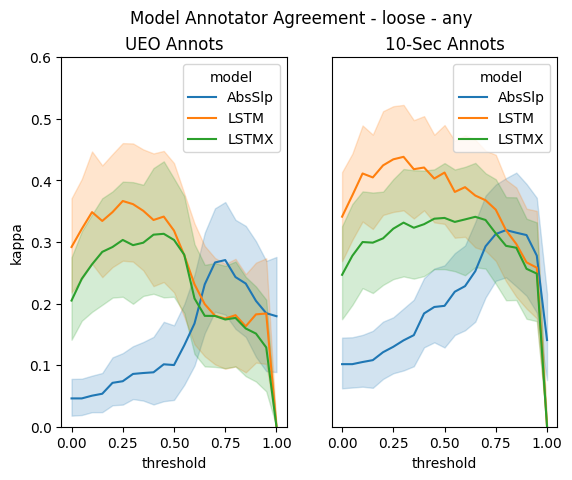

In [33]:
fig,axs = plt.subplots(1,2)
sns.lineplot(data=mdl_preds_long[mdl_preds_long.annot == f'ueo_rs_{mdl_anntype}_{anntype}_kappa'],x='threshold',y='kappa',hue='model',ax=axs[0])
axs[0].set_ylim((0,.6))
axs[0].set_title('UEO Annots')
sns.lineplot(data=mdl_preds_long[mdl_preds_long.annot == f'sec_rs_{mdl_anntype}_{anntype}_kappa'],x='threshold',y='kappa',hue='model',ax=axs[1])
axs[1].set_ylim((0,.6))
axs[1].set_yticks([])
axs[1].set_ylabel('')
axs[1].set_title('10-Sec Annots')
fig.suptitle(f'Model Annotator Agreement - {mdl_anntype} - {anntype}')

In [ ]:
mdl_preds_long[mdl_preds_long.annot == f'sec_rs_{mdl_anntype}_{anntype}_kappa']

,Patient,iEEG_ID,model,stim,approximate_onset,ueo_time_consensus,threshold,ueo_chs_strict,ueo_chs_loose,sec_chs_strict,...,ueo_any_rs,sec_consensus_rs,sec_any_rs,ueo_rs_strict_consensus_kappa,ueo_rs_strict_any_kappa,ueo_rs_loose_consensus_kappa,sec_rs_strict_consensus_kappa,sec_rs_strict_any_kappa,annot,kappa


In [ ]:
mask = mdl_preds_sorted.model == 'LSTM'
ueo_df = mdl_preds_sorted[mask].groupby('threshold')['ueo_rs_strict_consensus_kappa'].mean()
sec_df = mdl_preds_sorted[mask].groupby('threshold')['sec_rs_strict_consensus_kappa'].mean()

### Getting optimal threshold

In [ ]:
print(ueo_df.index[ueo_df.iloc[:].argmax()])
print(sec_df.index[sec_df.iloc[:].argmax()])
print(np.mean((ueo_df.index[ueo_df.iloc[:].argmax()],sec_df.index[sec_df.iloc[:].argmax()])))

0.30000000000000004
0.35000000000000003
0.32500000000000007


In [ ]:
sum((mdl_preds_long.annot == f'ueo_rs_{mdl_anntype}_{anntype}_kappa') & (mdl_preds_long.model == 'LSTM'))

1071

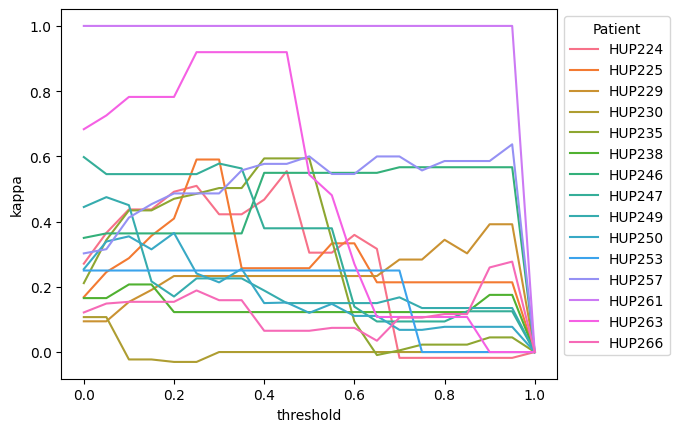

In [ ]:
ax = sns.lineplot(data=mdl_preds_long[(mdl_preds_long.annot == f'ueo_rs_{mdl_anntype}_{anntype}_kappa') & (mdl_preds_long.model == 'LSTM')],x='threshold',y='kappa',hue='Patient',errorbar=None)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))